In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.6 MB/s eta 0:00:00


In [ ]:
import re
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
import shap
from gensim.models.word2vec import Word2Vec

from tqdm import tqdm

In [ ]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

seed_everything(42)

In [ ]:
PATH = '/content/drive/MyDrive/Pywork/rec_books'

In [ ]:
df = pd.read_csv(PATH+'/train.csv')
df.head(3)

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books


## 전처리

In [ ]:
# preprocessing location
replaced_loc = {
    'spain': ['españa', 'catalunya spain'],
    'united states': ['united sates', 'usa (currently living in england)', 'los estados unidos de norte america', 'u.s.a.', 'us', 'united state',
                      'disgruntled states of america', 'u.s. of a.', 'u.s>', 'america', 'usa'],
    'u.a.e': ['united arab emirates'],
    'u.k.': ['united kindgonm', 'united kingdom', 'wales', 'england','scotland', 'uk'],
    'italia': ['l`italia'],
    'unknown': ['petrolwar nation', 'the world tomorrow', 'la chine éternelle!', 'la chine éternelle !', 'n/a', 'polk', 'pender',
                'we`re global!', 'n/a - on the road', 'the great white north', 'rutherford', 'here and there', 'k1c7b1', 'quit',
                'everywhere and anywhere', 'far away...', 'ee.uu', '']
}

z = df['Location'].apply(lambda x: x.split(','))

# 공백 제거
s = []
for l in z:
  ss = []
  for i in l:
    i = i.strip()
    ss.append(i)
  s.append(ss)

# 지역명 전처리
for i in range(len(s)):
  for nation in replaced_loc.keys():
    for name in replaced_loc[nation]:
      if s[i][-1] == name:
        s[i][-1] = name
        break

df['Location'] = s

In [ ]:
# 지역 임베딩
loc_vector = Word2Vec(sentences=s, vector_size=5, window=2, epochs=50, min_count=1, workers=1, seed=42)

def location_vectorizer(address:list) -> list:
  result = []
  for i in tqdm(range(len(address))):
    loc_vector.random.seed(42)
    _ = loc_vector.wv[address[i]].mean(axis=0)
    result.append(list(_))
  return result

s_ = location_vectorizer(s)
df['Location'] = s_

100%|██████████| 871393/871393 [00:35<00:00, 24376.40it/s]


In [ ]:
# 나이 전처리
df['Age'] = df['Age'].apply(lambda x: 8 if x <= 8 else x)
df['Age'] = df['Age'].apply(lambda x: 80 if x >= 80 else x)

In [ ]:
# 출판년도 전처리
m = df['Year-Of-Publication'].median()
df['Year-Of-Publication'] = df['Year-Of-Publication'].apply(lambda x: m if x==-1 else x)

## 모델 학습

In [ ]:
df_x = df[['User-ID',	'Book-ID', 'Age',	'Location', 'Book-Author', 'Year-Of-Publication', 'Publisher']].copy()
df_y = df[['Book-Rating']].copy()
train_x, val_x, train_y, val_y = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

cat_features = ['User-ID',	'Book-ID',	'Book-Author', 'Publisher']
embedding_features = ['Location']
train_data = Pool(data=train_x, label=train_y, cat_features=cat_features, embedding_features=embedding_features)
val_data = Pool(data=val_x, label=val_y, cat_features=cat_features, embedding_features=embedding_features)

In [ ]:
model = CatBoostRegressor(iterations=1000, loss_function='RMSE', random_seed=42, verbose=100)
model.fit(train_data)

Learning rate set to 0.115192
0:	learn: 3.7613978	total: 506ms	remaining: 8m 25s
100:	learn: 3.3481737	total: 44.6s	remaining: 6m 36s
200:	learn: 3.3389504	total: 1m 36s	remaining: 6m 23s
300:	learn: 3.3330774	total: 2m 27s	remaining: 5m 43s
400:	learn: 3.3291805	total: 3m 23s	remaining: 5m 3s
500:	learn: 3.3257595	total: 4m 17s	remaining: 4m 16s
600:	learn: 3.3230068	total: 5m 7s	remaining: 3m 24s
700:	learn: 3.3204006	total: 5m 58s	remaining: 2m 32s
800:	learn: 3.3178939	total: 6m 53s	remaining: 1m 42s
900:	learn: 3.3154887	total: 7m 42s	remaining: 50.9s
999:	learn: 3.3133592	total: 8m 37s	remaining: 0us


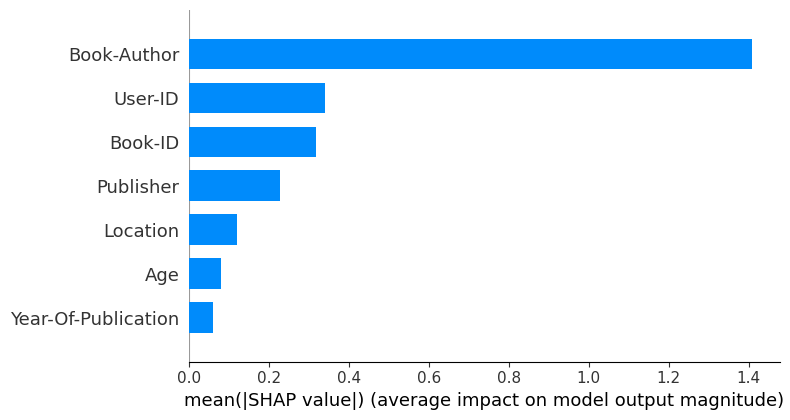

In [ ]:
approximate = model.get_feature_importance(train_data, type="ShapValues", shap_calc_type="Exact")[:, :-1]
shap.summary_plot(approximate, train_x, plot_type="bar")

In [ ]:
from sklearn.metrics import mean_squared_error
preds = model.predict(val_data)
mean_squared_error(val_y, preds, squared=False)

3.270563203765178

## 추론

In [ ]:
testdf = pd.read_csv(PATH+'/test.csv', encoding='UTF-8')

In [ ]:
z = testdf['Location'].apply(lambda x: x.split(','))

# 공백 제거
s = []
for l in z:
  ss = []
  for i in l:
    i = i.strip()
    ss.append(i)
  s.append(ss)

# 지역명 전처리
for i in range(len(s)):
  for j in range(len(s[i])):
    if s[i][j] in loc_vector.wv.key_to_index.keys():
      pass
    else:
      s[i][j] = 'unknown'

for i in range(len(s)):
  for nation in replaced_loc.keys():
    for name in replaced_loc[nation]:
      if s[i][-1] == name:
        s[i][-1] = name
        break

testdf['Location'] = location_vectorizer(s)

100%|██████████| 159621/159621 [00:05<00:00, 26714.74it/s]


In [ ]:
# 나이 전처리
testdf['Age'] = testdf['Age'].apply(lambda x: 8 if x <= 8 else x)
testdf['Age'] = testdf['Age'].apply(lambda x: 80 if x >= 80 else x)

In [ ]:
# 출판년도 전처리
testdf['Year-Of-Publication'] = testdf['Year-Of-Publication'].apply(lambda x: m if x==-1 else x)

In [ ]:
testdf = testdf[['User-ID',	'Book-ID', 'Age',	'Location', 'Book-Author',	'Year-Of-Publication',	'Publisher']].copy()
cat_features = ['User-ID',	'Book-ID',	'Book-Author', 'Publisher']
embedding_features = ['Location']

test_data = Pool(data=testdf, cat_features=cat_features, embedding_features=embedding_features)

In [ ]:
preds = model.predict(test_data)

In [ ]:
sam = pd.read_csv(PATH+'/sample_submission.csv', encoding='UTF-8')
sam['Book-Rating'] = preds
sam.to_csv(PATH+'/catboost_v2.csv', encoding='UTF-8', index=False)

In [ ]:
model.save_model(PATH+'/catboost_v2.cbm',format='cbm')